### Ensemble Classfiers

In [ ]:
import numpy as np
import torch as torch
import random
from sklearn.metrics import classification_report
from random import randint

#### Get the dataset

#### Load the required models

In [ ]:
MODEL1_PATH = 'efficientnet_b0.pth'
MODEL2_PATH = 'googlenet.pth'
MODEL3_PATH = 'mobilenet.pth'

In [ ]:
# model1 = TheModelClass(*args, **kwargs)
# model1.load_state_dict(torch.load(MODEL1_PATH))
model1 = torch.load(MODEL1_PATH)
model1.eval()
model2 = torch.load(MODEL2_PATH)
model2.eval()
model3 = torch.load(MODEL3_PATH)
model3.eval()

In [ ]:
# Importing data
data = []
labels = []
model1_preds = model1(data) # data predictions from model1
model2_preds = model2(data) # data predictions from model2
model3_preds = model3(data) # data predictions from model3

# Expected outputs
num_of_classes = 30
expected_output_labels = labels # Expected output labels, assuming that all models are working with the same images
data_outputs = np.zeros((expected_output_labels.size, num_of_classes))
data_outputs[np.arange(expected_output_labels.size), expected_output_labels] = 1

#### Helper Functions

In [ ]:
def weighted_probability(num_of_classfiers, num_of_classes, networks_outputs, curr_weight_combi):
    '''
    Given an array contain the predictions from each classifier and the weights to be assigned to each classifier, 
    this function computes the final weighted probability.
    '''
    result = [0 for i in range(0, num_of_classes)]
    sum_of_weights = 0

    for i in range(0, num_of_classfiers):
        curr_network_output = networks_outputs[i]
        curr_weight = curr_weight_combi[i]
        sum_of_weights += curr_weight

        for j in range(0, num_of_classes):
            result[j] += curr_network_output[j] * curr_weight
    
    for k in range(0, num_of_classes):
        result[k] = result[k] / sum_of_weights

    return result


def fitness(y_pred, y_true): 
    '''
    Calculates the negative log loss.
    '''
    return torch.nn.NLLLoss(y_true, y_pred)


def mutate(weight_combi):
    '''
    Randomly changes a given float number (up to 2%). 
    '''
    for i in range(0, len(weight_combi)):
        weight_combi[i] = weight_combi[i] * random.uniform(0.99, 1.01)
    
    return weight_combi


def cross_over(num_of_classifiers, parent_1, parent_2):
    '''
    Given 2 different possible weight combination, this function produces a final weight combination by randomly extracting 
    weight elements from either parent combinations.
    '''
    cut = random.randint(0, num_of_classifiers - 1)
    new_weight_combi = parent_1[:cut] 
    new_weight_combi.extend(parent_2[cut:])

    return new_weight_combi


def generate_possible_weight_combis(num_of_classifiers, num_of_combis, weight_limit):
    '''
    Produces combinations of weights that can be assigned to each of the classifiers. 
    '''
    possible_weight_combis = []

    while (num_of_combis > 0):
        curr_weight_combi = []

        while (len(curr_weight_combi) < num_of_classifiers):
            curr_weight = random.uniform(0, weight_limit)
            curr_weight_combi.append(curr_weight)
        
        possible_weight_combis.append(curr_weight_combi)
        num_of_combis -= 1
    
    return possible_weight_combis


#### Genetic Algorithm to find the optimal weights for each classifier

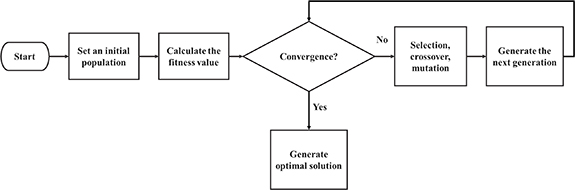

Source: https://iopscience.iop.org/article/10.1088/2632-2153/ad10cf#mlstad10cfs2

In [ ]:
# Defining essential variables
num_of_classifiers = 3
num_of_classes = 30
num_of_required_weight_combis = 20
weight_limit = 100
possible_weight_combis = generate_possible_weight_combis(num_of_classifiers, num_of_required_weight_combis, weight_limit)
max_num_of_iters = 10

while (max_num_of_iters > 0):
    # Step 1: Randomly chossing 50% of the dataset to calculate the fitness scores for
    chosen_y_true = []
    chosen_y_model1_pred = []
    chosen_y_model2_pred = []
    chosen_y_model3_pred = []

    required_num_of_samples = len(data_outputs) // 2 # Rounding down

    random_indices = []
    while required_num_of_samples > 0:
        curr_index = randint(0, len(data_outputs) - 1)

        if (curr_index not in random_indices):
            chosen_y_true.append(data_outputs[curr_index])
            chosen_y_model1_pred.append(model1_preds[curr_index])
            chosen_y_model2_pred.append(model2_preds[curr_index])
            chosen_y_model3_pred.append(model3_preds[curr_index])

            random_indices.append(curr_index)
            required_num_of_samples -= 1

    # Step 2: Calculate the average fitness scores for each of the possible weight combinations
    fitness_and_weights = []

    for weights in possible_weight_combis:
        accumulated_fitness_score = 0
        num_of_samples = len(chosen_y_true)

        for i in range(0, num_of_samples):
            network_outputs = [chosen_y_model1_pred[i], chosen_y_model2_pred[i], chosen_y_model3_pred[i]]
            y_pred = weighted_probability(num_of_classifiers, num_of_classes, network_outputs, weights)
            y_true = chosen_y_true[i]
            fitness_score = fitness(y_pred, y_true)
            accumulated_fitness_score += fitness_score
        
        avg_fitness_score = accumulated_fitness_score / num_of_samples
        fitness_and_weights.append((avg_fitness_score, weights))

    # Step 3: Rank the weight combis from best to worse
    fitness_and_weights.sort() # The combis with the lowest log loss is at the start

    # Step 4: Selecting parents
    parents = []
    curr_index = 0

    # Selecting top 20% of the weight combis
    top_20_percent = int(len(fitness_and_weights) // 5) # Rounding down
    while (top_20_percent > 0):
        parents.append(fitness_and_weights[curr_index][1])
        top_20_percent -= 1
        curr_index += 1

    # Randomly choosing another 10% of the weight combinations
    another_10_percent = int(len(fitness_and_weights) // 10)  # Rounding down
    while(another_10_percent > 0):
        random_score_and_parent = random.choice(fitness_and_weights[curr_index:])
        parents.append(random_score_and_parent[1])
        fitness_and_weights.remove(random_score_and_parent)

        another_10_percent -= 1

    # Step 5: Randomly mutate 5% of the selected parents
    num_of_parents_to_mutate = max(1, int(len(parents) // 20))  # Rounding down
    index_of_parents_to_mutate = [random.randint(0, len(parents) - 1) for i in range(0, num_of_parents_to_mutate)]

    for index in index_of_parents_to_mutate:
        parents[index] = mutate(parents[index])

    # Step 6: Randomly cross over parents to produce new set of weight combinations
    new_weight_combis = []
    index_of_crossed_parents = []
    num_of_curr_weights = 0

    while (num_of_curr_weights < num_of_required_weight_combis):
        chosen_parents = (random.randint(0, len(parents) - 1), random.randint(0, len(parents) - 1))
        parent_1 = parents[chosen_parents[0]]
        parent_2 = parents[chosen_parents[1]]

        if (parent_1 != parent_2 and chosen_parents not in index_of_crossed_parents):
            new_weight_combi = cross_over(num_of_classifiers, parent_1, parent_2)
            new_weight_combis.append(new_weight_combi)
            num_of_curr_weights += 1

    possible_weight_combis = new_weight_combis
    print(possible_weight_combis) # For testing

    max_num_of_iters -= 1

# Step 7: Select the best weights combination
final_fitness_and_weights = []

for weights in possible_weight_combis:
    accumulated_fitness_score = 0
    num_of_samples = 0

    for i in range(0, len(chosen_y_true)):
            network_outputs = [chosen_y_model1_pred[i], chosen_y_model2_pred[i], chosen_y_model3_pred[i]]
            y_pred = weighted_probability(num_of_classifiers, num_of_classes, network_outputs, weights)
            y_true = chosen_y_true[i]
            fitness_score = fitness(y_pred, y_true)
            accumulated_fitness_score += fitness_score

            num_of_samples += 1
    
    avg_fitness_score = accumulated_fitness_score / num_of_samples
    final_fitness_and_weights.append((avg_fitness_score, weights))

final_fitness_and_weights.sort() # The combis with the lowest log loss is at the start
best_weights = final_fitness_and_weights[0][1]
print("The best weight combination is: " + str(best_weights))
print("The fitness score of this combination is: " + str(final_fitness_and_weights[0][0]))

Best weights optained from running the above multiple times: [2, 54, 44]

#### Computing the performance of the ensemble model

In [ ]:
best_weights = [2, 54, 44]

In [ ]:
# Get final prediction of data based on the best weight combination
final_predictions = [weighted_probability(num_of_classifiers, num_of_classes, [model1_preds[i], model2_preds[i], model3_preds[i]], best_weights) for i in range(0, len(model1_preds))]
final_predictions = np.array(final_predictions)

# Get the final classification report
final_predictions = np.argmax(final_predictions, axis=1)
expected_output_labels = np.argmax(data_outputs, axis=1)
print(classification_report(expected_output_labels, final_predictions, target_names=labels))
